In [1]:
import os
import numpy as np
import cv2
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

root_folder = r'complete_ms_data'
target_size = 64

cropped_images = []
for subdir in os.listdir(root_folder):
    subdir_path = os.path.join(root_folder, subdir)
    if not os.path.isdir(subdir_path):
        continue

    for subdir2 in os.listdir(subdir_path):
        subdir2_path = os.path.join(subdir_path, subdir2)
        if not os.path.isdir(subdir2_path):
            continue

        stacked_img = np.empty([512, 512, 31])
        for i in range(1, 32):
            img_path = os.path.join(subdir2_path, f"{subdir2}_{i:02d}.png")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            stacked_img[:, :, i-1] = img

        # Loop through the stacked image and extract crops
        for h in range(0, 512-target_size+1, target_size//2):
            for w in range(0, 512-target_size+1, target_size//2):
                cropped_img = stacked_img[h:h+target_size, w:w+target_size, :]
                cropped_images.append(cropped_img)

cropped_images = np.array(cropped_images)

In [2]:
LowResHSI = []
HiResRGB = []

for img in cropped_images:
    # Low-resolution HSI
    low_res_img = cv2.resize(img, (8, 8), interpolation=cv2.INTER_AREA)
    LowResHSI.append(low_res_img)
    
    # High-resolution RGB
    high_res_img = np.zeros((64, 64, 3))
    for i in range(3):
        high_res_img[:,:,i] = np.mean(img[:, :, i*10:(i+1)*10], axis=2)
    HiResRGB.append(high_res_img)

LowResHSI = np.array(LowResHSI)
HiResRGB = np.array(HiResRGB)

print("low_res_images images shape:", LowResHSI.shape)
print("high_res_images images shape:", HiResRGB.shape)

low_res_images images shape: (3825, 8, 8, 31)
high_res_images images shape: (3825, 64, 64, 3)


In [3]:

# Create the target dataset (original high resolution hyperspectral images)
y = cropped_images

# Create the input dataset (low resolution hyperspectral images and high resolution RGB images)
# No need to concatenate the inputs, keep them separate
X_low_res_hsi = LowResHSI
X_hi_res_rgb = HiResRGB

print("Low resolution HSI images shape:", X_low_res_hsi.shape)
print("High resolution RGB images shape:", X_hi_res_rgb.shape)
print("Target images shape:", y.shape)

Low resolution HSI images shape: (3825, 8, 8, 31)
High resolution RGB images shape: (3825, 64, 64, 3)
Target images shape: (3825, 64, 64, 31)


In [4]:
from sklearn.model_selection import train_test_split

# Split the datasets into training and testing sets
X_low_res_hsi_train, X_low_res_hsi_test, y_train, y_test = train_test_split(X_low_res_hsi, y, test_size=0.2, random_state=42)
X_hi_res_rgb_train, X_hi_res_rgb_test = train_test_split(X_hi_res_rgb, test_size=0.2, random_state=42)


print(f"X_low_res_hsi_train shape: {X_low_res_hsi_train.shape}")
print(f"X_hi_res_rgb_train shape: {X_hi_res_rgb_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_low_res_hsi_test shape: {X_low_res_hsi_test.shape}")
print(f"X_hi_res_rgb_test shape: {X_hi_res_rgb_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_low_res_hsi_train shape: (3060, 8, 8, 31)
X_hi_res_rgb_train shape: (3060, 64, 64, 3)
y_train shape: (3060, 64, 64, 31)
X_low_res_hsi_test shape: (765, 8, 8, 31)
X_hi_res_rgb_test shape: (765, 64, 64, 3)
y_test shape: (765, 64, 64, 31)


In [5]:
# Normalize the input data
# max_pixel_value = np.max(X_low_res_hsi_train)
# Calculate the maximum pixel value

max_pixel_value = 255
X_low_res_hsi_train = X_low_res_hsi_train / max_pixel_value
X_low_res_hsi_test = X_low_res_hsi_test / max_pixel_value

max_pixel_value = 255
X_hi_res_rgb_train = X_hi_res_rgb_train / max_pixel_value
X_hi_res_rgb_test = X_hi_res_rgb_test / max_pixel_value

max_pixel_value = 255
y_train = y_train / max_pixel_value
y_test = y_test / max_pixel_value


In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
from keras.optimizers import Adam

from keras.layers import BatchNormalization, Dropout, LeakyReLU, Add

def create_model():
    # Define the input layers
    hi_res_rgb_input = Input(shape=(64, 64, 3))
    low_res_hsi_input = Input(shape=(8, 8, 31))

    # Define the encoder
    def encoder(input_layer, filters, num_channels):
        conv1 = Conv2D(num_channels, (3, 3), padding='same')(input_layer)
        conv1 = BatchNormalization()(conv1)
        conv1 = LeakyReLU()(conv1)
        conv2 = Conv2D(num_channels, (3, 3), padding='same')(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = LeakyReLU()(conv2)
        conv2 = Add()([conv1, conv2])
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
        return pool1

    # RGB branch
    rgb_branch = encoder(hi_res_rgb_input, 64, 3)

    # Upsample the low-resolution HSI branch to match the RGB branch
    upsampled_hsi_branch = UpSampling2D(size=(8, 8))(low_res_hsi_input)
    hsi_branch = encoder(upsampled_hsi_branch, 64, 31)

    # Fusion
    fused = concatenate([rgb_branch, hsi_branch])

    # Define the decoder
    def decoder(input_layer, filters):
        up1 = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(input_layer)
        up1 = BatchNormalization()(up1)
        up1 = LeakyReLU()(up1)
        up1 = Dropout(0.2)(up1)
        conv2 = Conv2D(filters, (3, 3), padding='same')(up1)
        conv2 = BatchNormalization()(conv2)
        conv2 = LeakyReLU()(conv2)
        return conv2

    # Decoder
    output = decoder(fused, 64)
    # Using Conv2DTranspose to upscale to the original spatial resolution
    output = Conv2DTranspose(31, (3, 3), strides=(1, 1), activation='sigmoid', padding='same')(output)
    
    # Define the model
    model = Model(inputs=[hi_res_rgb_input, low_res_hsi_input], outputs=[output])

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model


In [7]:
# Create an instance of the model
model = create_model()

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 31)]   0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 64, 64, 31)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 3)    84          ['input_1[0][0]']                
                                                                                              

In [8]:
# Train the model
history = model.fit(
    [X_hi_res_rgb_train, X_low_res_hsi_train],  # Input data
    y_train,  # Target data
    batch_size=64,  # Adjust batch size as needed
    epochs=10,  # Adjust number of epochs as needed
    validation_data=([X_hi_res_rgb_test, X_low_res_hsi_test], y_test)  # Validation data
)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate([X_hi_res_rgb_test, X_low_res_hsi_test], y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)


Epoch 1/10
48/48 [==============================] - 136s 3s/step - loss: 0.1353 - accuracy: 0.0233 - val_loss: 0.1614 - val_accuracy: 0.0269
Epoch 2/10
48/48 [==============================] - 130s 3s/step - loss: 0.0524 - accuracy: 0.0190 - val_loss: 0.1048 - val_accuracy: 0.0506
Epoch 3/10
48/48 [==============================] - 120s 2s/step - loss: 0.0202 - accuracy: 0.0267 - val_loss: 0.0562 - val_accuracy: 0.0197
Epoch 4/10
48/48 [==============================] - 107s 2s/step - loss: 0.0107 - accuracy: 0.0365 - val_loss: 0.0293 - val_accuracy: 0.0189
Epoch 5/10
48/48 [==============================] - 114s 2s/step - loss: 0.0073 - accuracy: 0.0490 - val_loss: 0.0163 - val_accuracy: 0.0234
Epoch 6/10
48/48 [==============================] - 126s 3s/step - loss: 0.0057 - accuracy: 0.0604 - val_loss: 0.0097 - val_accuracy: 0.0445
Epoch 7/10
48/48 [==============================] - 135s 3s/step - loss: 0.0048 - accuracy: 0.0762 - val_loss: 0.0064 - val_accuracy: 0.0907
Epoch 8/10
48

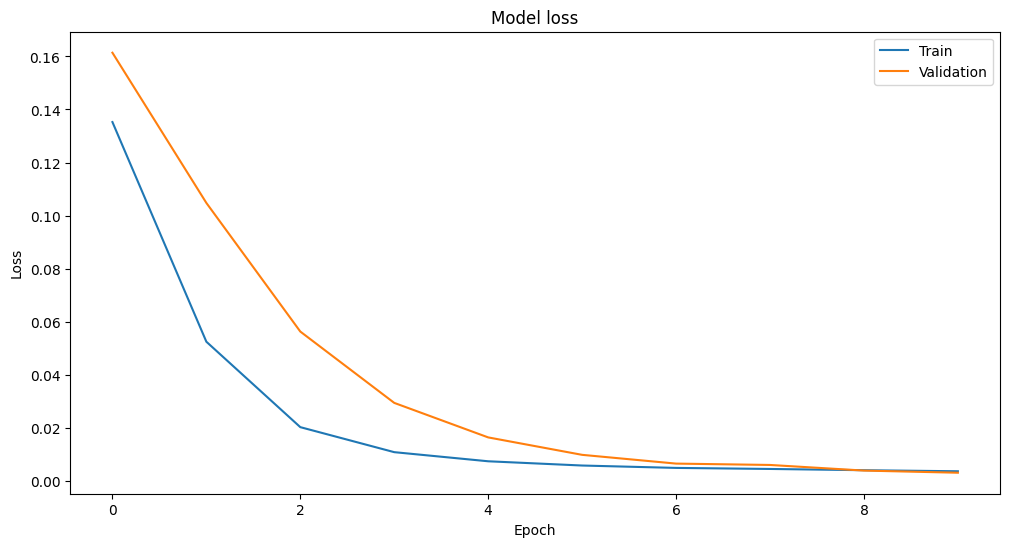

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


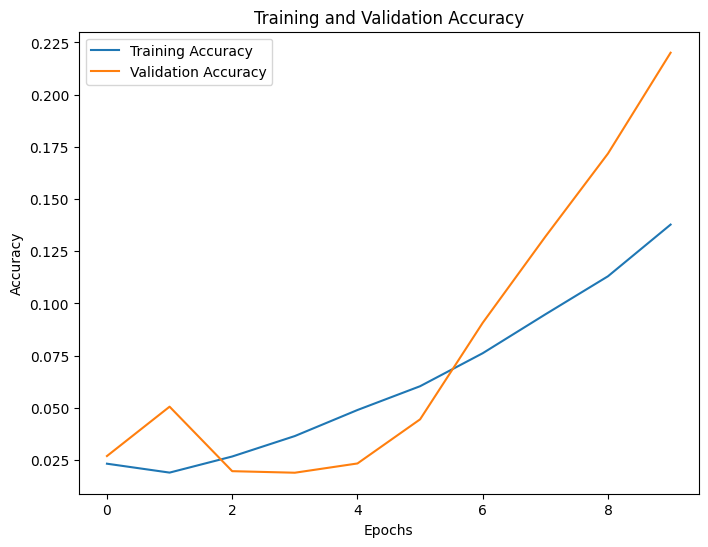

In [10]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# Predict on the first 10 test images.
predictions = model.predict([X_hi_res_rgb_test, X_low_res_hsi_test])

24/24 [==============================] - 8s 272ms/step


In [12]:
print(predictions.shape)

(765, 64, 64, 31)


In [13]:
print(y_test[0] * 255)

[[[23. 16.  9. ...  4.  6.  9.]
  [23. 16.  8. ...  3.  5.  9.]
  [23. 16.  8. ...  3.  5.  9.]
  ...
  [16. 11.  5. ...  1.  1.  2.]
  [16. 11.  5. ...  1.  1.  2.]
  [15. 11.  5. ...  0.  1.  1.]]

 [[24. 16.  8. ...  3.  5.  9.]
  [23. 16.  8. ...  3.  5.  9.]
  [23. 16.  8. ...  3.  5.  9.]
  ...
  [17. 11.  5. ...  1.  2.  3.]
  [16. 11.  5. ...  1.  1.  2.]
  [16. 11.  5. ...  1.  1.  2.]]

 [[23. 16.  8. ...  3.  5.  8.]
  [23. 16.  8. ...  3.  5.  9.]
  [23. 16.  8. ...  3.  5.  9.]
  ...
  [17. 11.  6. ...  2.  2.  4.]
  [17. 11.  5. ...  1.  2.  3.]
  [16. 11.  5. ...  1.  2.  3.]]

 ...

 [[20. 14.  7. ...  2.  4.  6.]
  [21. 14.  7. ...  2.  3.  7.]
  [21. 14.  7. ...  2.  3.  7.]
  ...
  [20. 14.  7. ...  3.  4.  8.]
  [21. 14.  7. ...  3.  5.  9.]
  [20. 14.  7. ...  3.  5.  9.]]

 [[20. 14.  7. ...  2.  3.  6.]
  [21. 14.  7. ...  2.  3.  6.]
  [21. 14.  7. ...  3.  4.  7.]
  ...
  [21. 14.  8. ...  3.  5.  8.]
  [20. 14.  7. ...  3.  4.  8.]
  [21. 14.  7. ...  3.  4.  

In [15]:
print(predictions[0] * 255)

[[[34.58658   50.44333   34.376713  ... 33.227505  34.251762  30.607914 ]
  [30.842192  28.974373  15.4879675 ...  8.986885  10.487391  28.946518 ]
  [15.697847  23.942978  11.875425  ... 12.163126  25.065521  19.59045  ]
  ...
  [26.47382   26.73096   14.300358  ...  9.435458  11.225585  25.997755 ]
  [25.41011   31.7428    16.384375  ... 13.256979  33.143856  22.30002  ]
  [43.481083  45.61828   62.91616   ... 29.258444  46.509224  51.93755  ]]

 [[47.947876  24.639505  14.537784  ... 33.058098  35.375378  19.145975 ]
  [14.294515   9.145978  12.612876  ... 14.424368  14.179615   7.972871 ]
  [11.60702   14.776024   7.8931274 ...  8.2332     7.2221513  7.913869 ]
  ...
  [14.121109   8.873351  10.593921  ... 12.742601  12.208041   8.416869 ]
  [14.707264  14.091493  10.769448  ... 13.435048   7.363381  10.61111  ]
  [14.842905  25.468702  33.64293   ... 26.048866  38.965664  22.512033 ]]

 [[27.12356   15.446747  24.237886  ... 20.88173   15.155318  17.120825 ]
  [10.079085   9.06361

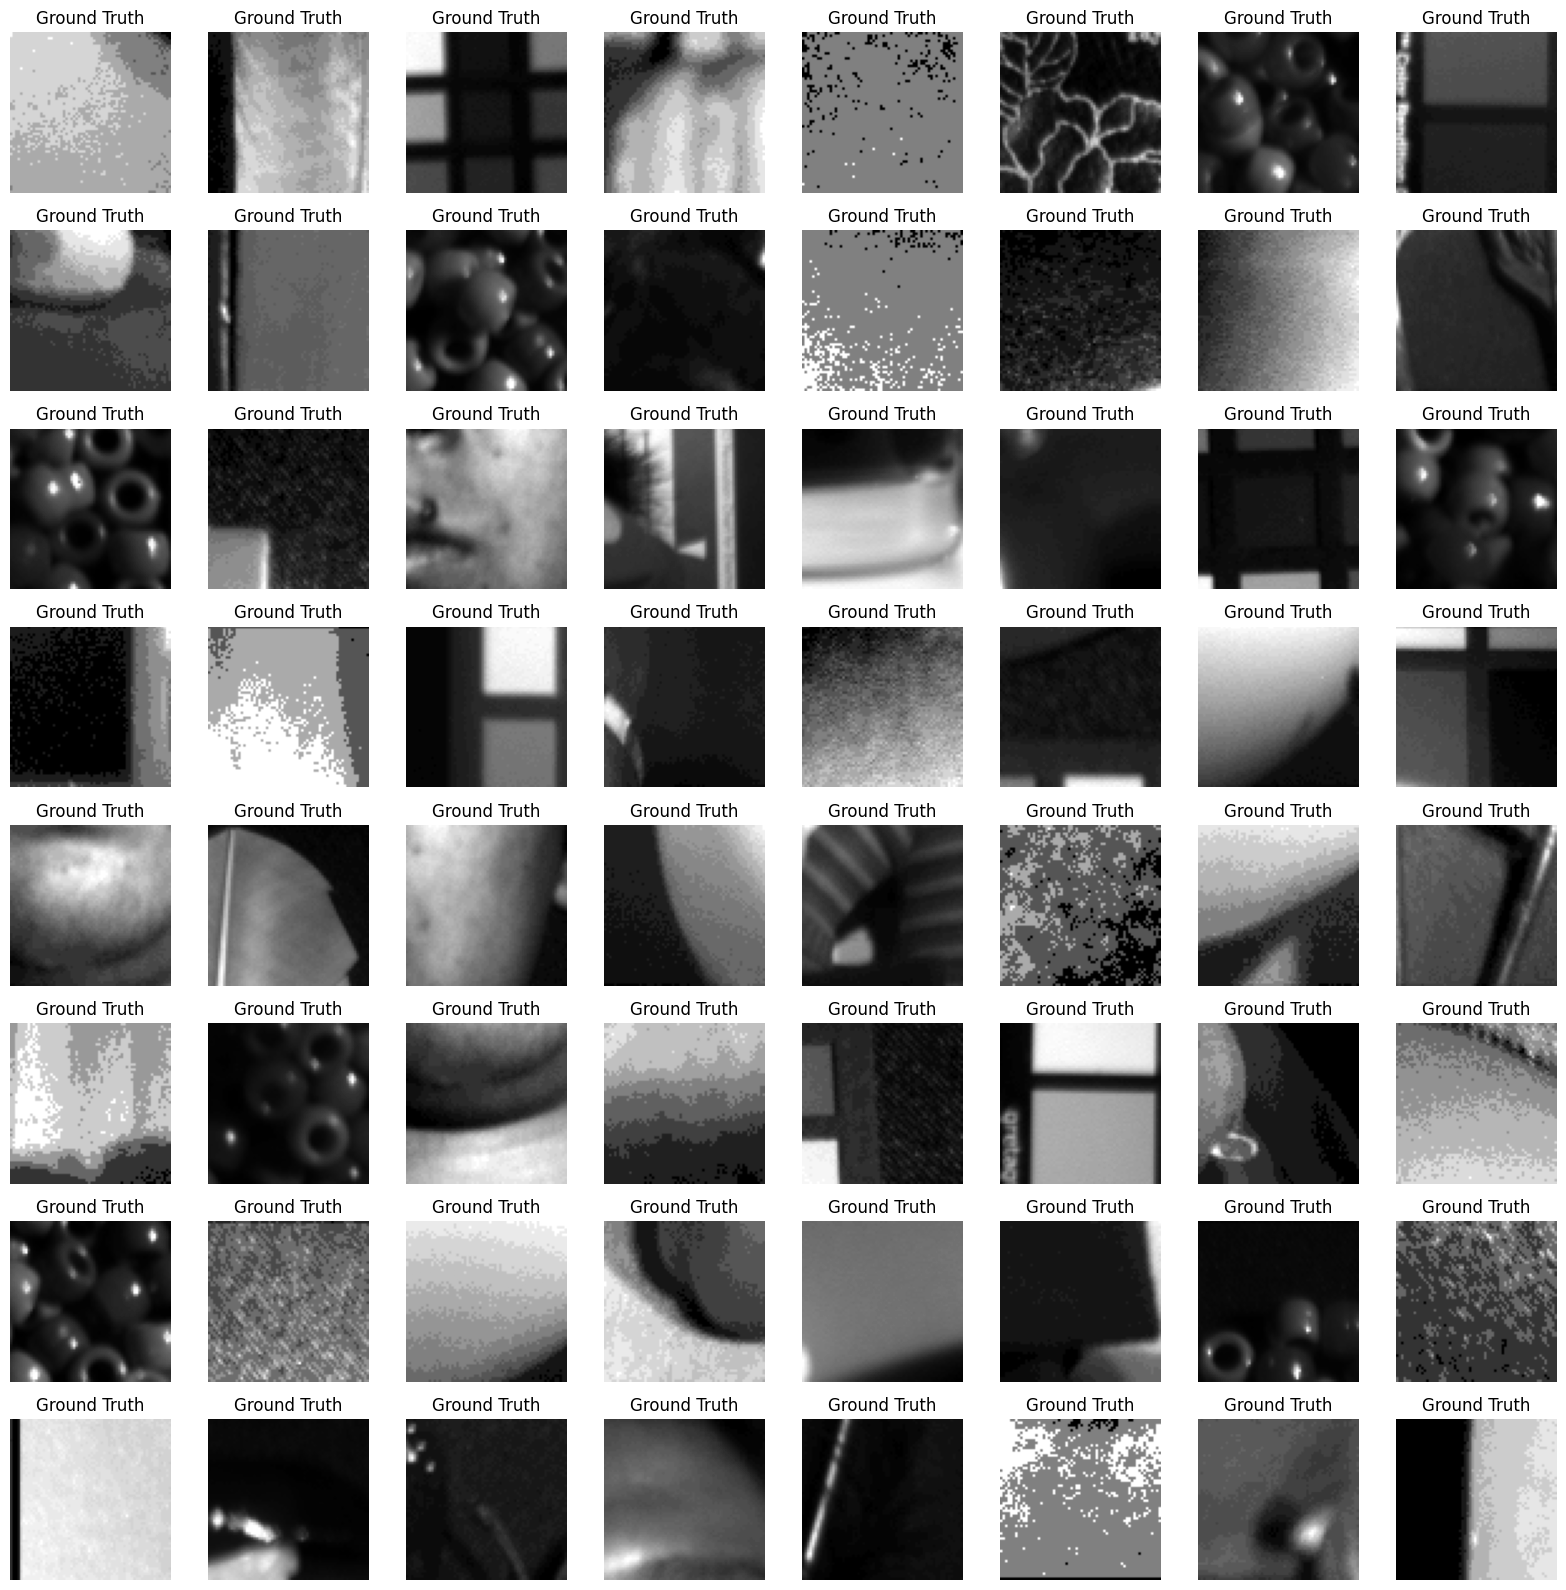

<Figure size 640x480 with 0 Axes>

In [24]:
# Adjust the pixel values of the ground truth and predictions back to the original scale
y_test_adj = y_test * max_pixel_value
predictions_adj = predictions * max_pixel_value

# Compute the average of the first three bands to represent RGB
y_test_adj_avg = np.mean(y_test_adj[:, :, :, :3], axis=-1)
predictions_adj_avg = np.mean(predictions_adj[:, :, :, :3], axis=-1)

# Plot the segments in an 8x8 grid
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    # Ground truth - display the average RGB
    ax.imshow(y_test_adj_avg[i, :, :].astype(int), cmap='gray')
    ax.set_title('Ground Truth')
    ax.axis('off')
plt.tight_layout()
plt.show()    


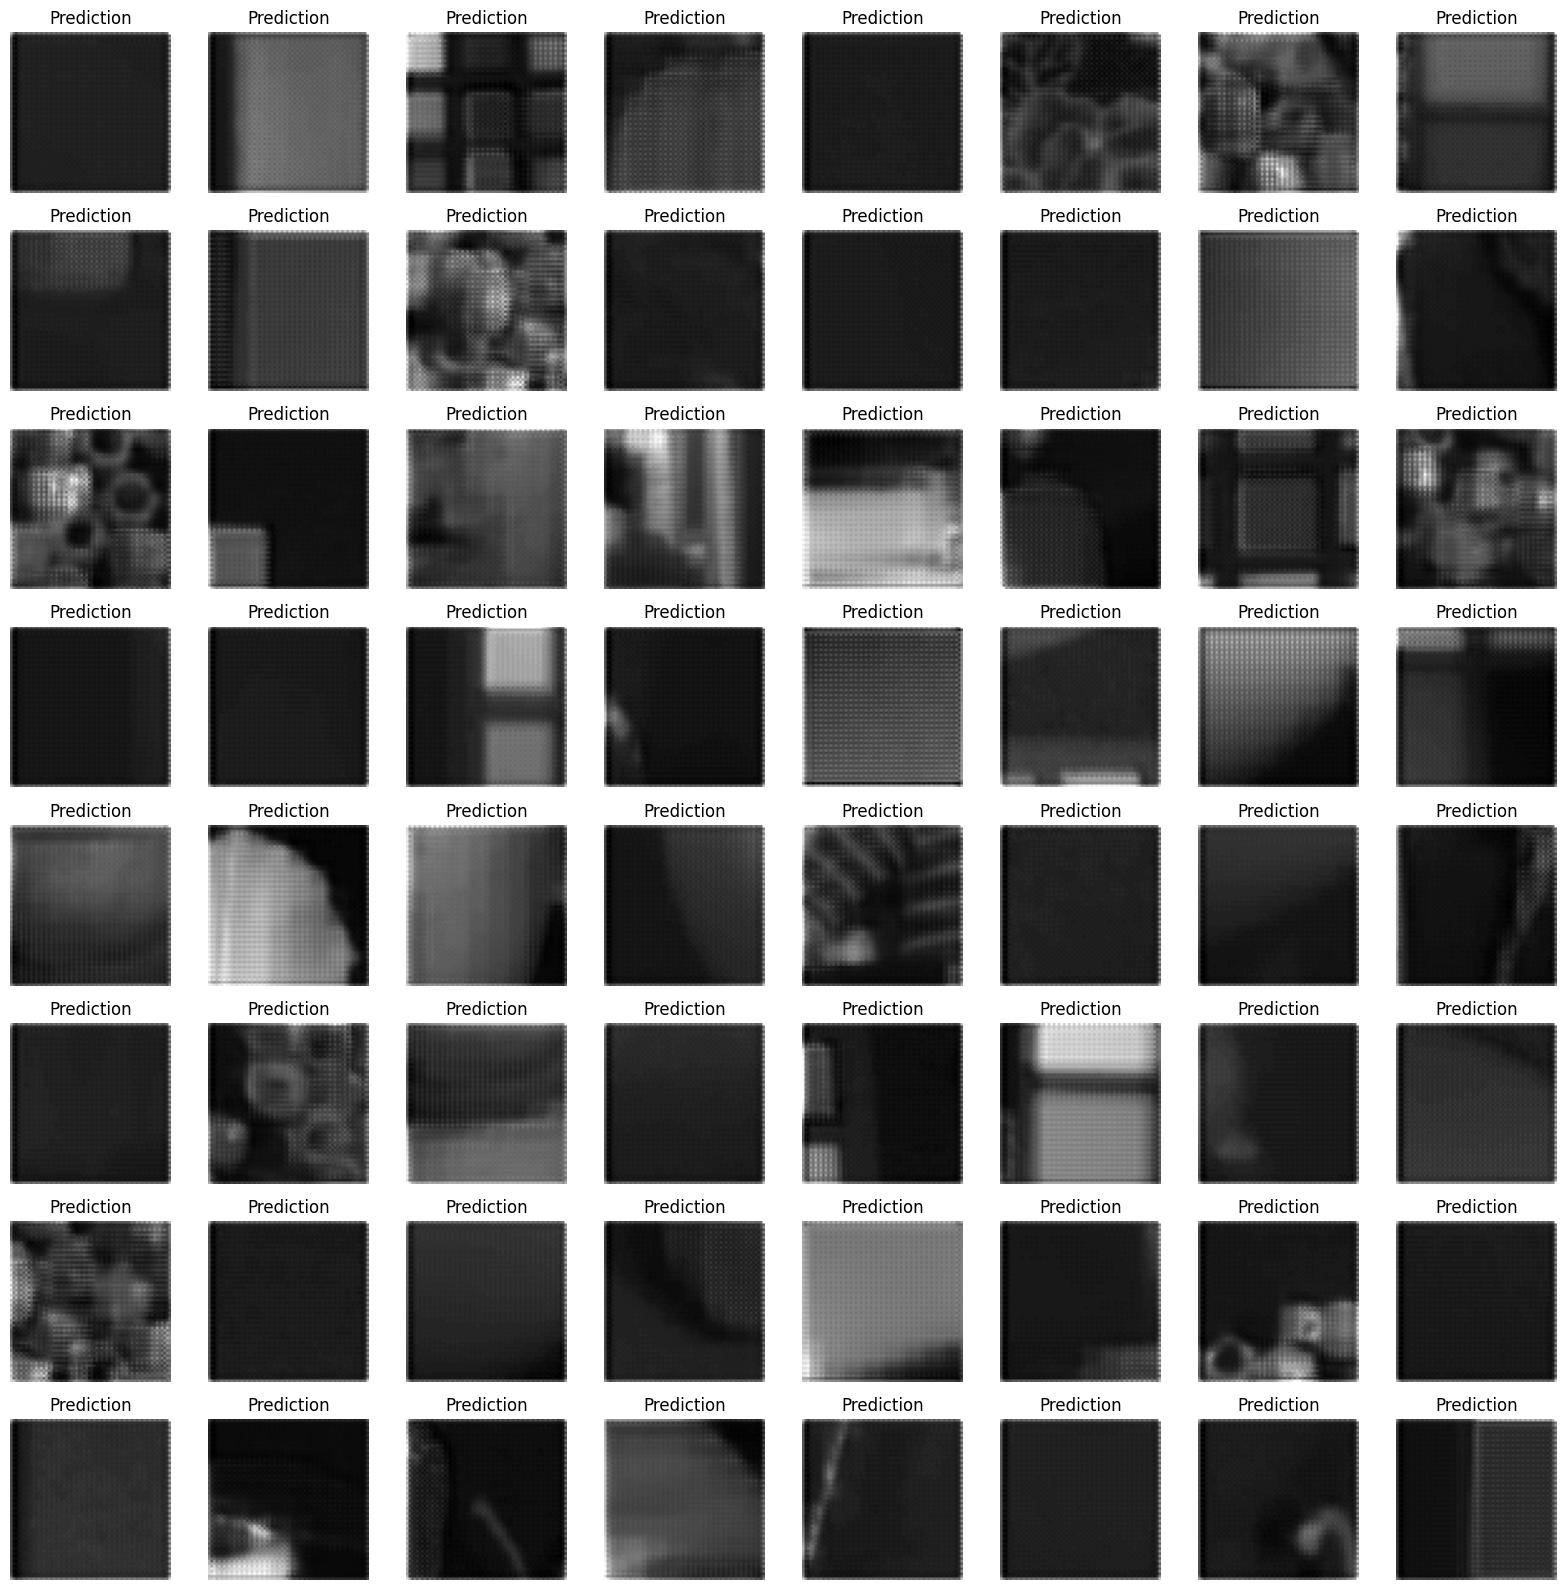

In [26]:
# Plot the segments in an 8x8 grid
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    # Prediction - display the average RGB
    ax.imshow(predictions_adj_avg[i, :, :].astype(int), cmap='gray')
    ax.set_title('Prediction')
    ax.axis('off')    
plt.tight_layout()
plt.show()